# Notebook for minimal experiments and setup checks

## Training Workflow: Joint Optimization with Feedback

**Input:** Audio Chunks + Text/Speech Targets  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Chunked Audio Preprocessing**  
&nbsp;&nbsp;&nbsp;&nbsp;2s chunks, 0.5s overlap to simulate streaming  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Shared Encoder** (SeamlessM4T / Wav2Vec2)  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Acoustic Features**  
&nbsp;&nbsp;&nbsp;&nbsp;├────────────┬──────────────┐  
&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Text Decoder**  **Speech Decoder**  **Context Buffer**  
(S2T Path)      (S2S Path)       (Stores recent chunks)  
&nbsp;&nbsp;&nbsp;&nbsp;↓          ↓  
Text Output     Speech Units  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|        **[Neural Vocoder]**  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|       Synthesized Audio  
&nbsp;&nbsp;&nbsp;&nbsp;|          ↓  
&nbsp;&nbsp;&nbsp;&nbsp;└───────────┬───────────┘  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;      ↓  

### Feedback Mechanism 1 — Semantic Consistency Check
- Run ASR on synthesized audio  
- Compare with text output  
- Compute similarity loss

### Feedback Mechanism 2 — Confidence Estimation
- Extract prediction scores  
- Estimate model uncertainty  

### Combined Loss Function

$$
\text{Total Loss} = L_{\text{text}} + L_{\text{speech}} + \lambda_1 L_{\text{consistency}} + \lambda_2 L_{\text{confidence}}
$$


### Backpropagation
Update all components jointly
  (Encoder, Decoders, Vocoder, Feedback modules)


## Inference Mode: Streaming with Adaptive Feedback

**Live Microphone** or **Streaming Audio File**  
&nbsp;&nbsp;&nbsp;&nbsp;↓ (continuous stream)  
**Audio Buffer Manager**  
&nbsp;&nbsp;&nbsp;&nbsp;Accumulates audio in overlapping chunks  
&nbsp;&nbsp;&nbsp;&nbsp;Chunk: 2.0s, Hop: 0.5s  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Every 0.5s, new chunk available  
**Chunk Queue** ← maintains last 3–4 chunks for context  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Process immediately (Similar to Wait-K)

**Shared Encoder**  
&nbsp;&nbsp;&nbsp;&nbsp;↓  
Features extracted   
&nbsp;&nbsp;&nbsp;&nbsp;├────────────────────┬─────────────────┐  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
**Text Decoder**  **Speech Decoder**  **Confidence Estimator**  
(S2T Path)      (S2S Path)       (Estimates reliability)  
&nbsp;&nbsp;&nbsp;&nbsp;↓&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;                    ↓     &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;            ↓  
Text (partial)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Speech Units  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Confidence Score  
&nbsp;&nbsp;&nbsp;&nbsp;|                |  
&nbsp;&nbsp;&nbsp;&nbsp;|                ↓  
&nbsp;&nbsp;&nbsp;&nbsp;|           &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;**Vocoder**  
&nbsp;&nbsp;&nbsp;&nbsp;|              &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
&nbsp;&nbsp;&nbsp;&nbsp;|           &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Audio Output  
&nbsp;&nbsp;&nbsp;&nbsp;|              &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  
&nbsp;&nbsp;&nbsp;&nbsp;└───────────────────────┬───────────────────┘  
&nbsp;&nbsp;&nbsp;&nbsp;         &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;↓  

### Adaptive Decision Gate
- **High Confidence (> 0.90):**  
  Emit immediately
  Play audio + display text   

- **Medium Confidence (0.75–0.90):**  
  Wait for 1 more chunk  
  Re-process with more context

- **Low Confidence (< 0.75):**  
  Buffer 2–3 more chunks  
  Re-process with extended context  


### Feedback Verification *(optional for high-quality mode)*
- Run ASR on output audio  
- Check semantic match with text  
- Flag if mismatch detected  

### Output Emission
- Play synthesized speech  
- Display text translation  
- Log confidence + similarity metrics  

### Boundary Detection
- Silence detected → Reset context buffer  
- Punctuation in text → Segment boundary  
- Confidence drop → Potential speaker change  

Loop back to **Audio Buffer Manager**  
*(Next chunk ready every 0.5 s)*


# Install dependencies

In [1]:
!pip install git+https://github.com/huggingface/transformers.git sentencepiece

  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-seo3rbzp
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-seo3rbzp
  Resolved https://github.com/huggingface/transformers.git to commit 02c324f43fe0ef5d484e846417e5f3bf4484524c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 502.0/502.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.1 MB/s eta 0:00:00
  Created wheel for transformers: filename=transformers-5.0.0.dev0-py3-none-any.whl size=11349332 sha256=d7ec57dd5e8a8037967e8ab2a321454a340b419f8c1ba1115a29fd6ddbd76630
  Stored in directory: /tmp/pip-ephem-wheel-cache-82exeg15/wheels/54/cb/3f/83103de5575c534436d6a4686686dead458238dfaf1147e98d
Successfully built transformers
  Attempting uninstall: huggingface-hub
    Foun

In [2]:
!pip install -q transformers>=4.35.0 datasets soundfile librosa torch torchaudio accelerate sentencepiece jiwer matplotlib scikit-learn scipy

# Code

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Load Dataset

In [2]:
# Load dataset
import os
import tarfile
input_path = '/content/drive/My Drive/dataset.gz'
extract_directory = '/content/dataset'
os.makedirs(extract_directory, exist_ok=True)
with tarfile.open(input_path, 'r:gz') as tar:
    tar.extractall(extract_directory)

print('Extracted files successfully')

/tmp/ipython-input-3153388601.py:8: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(extract_directory)


Extracted files successfully


### EDA on Dataset

In [33]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from IPython.display import Audio
import glob
import warnings
warnings.filterwarnings('ignore')


In [23]:
# Structure of dataset
audio_path = None
for root, dirs, files in os.walk(extract_directory):
    print(root, "===", len(files), 'files')
    if os.path.basename(root) == 'clips':
      audio_path = root


/content/dataset === 0 files
/content/dataset/cv-corpus-22.0-2025-06-20 === 0 files
/content/dataset/cv-corpus-22.0-2025-06-20/cy === 10 files
/content/dataset/cv-corpus-22.0-2025-06-20/cy/clips === 115915 files


In [5]:
# Total audio files
audio_files = glob.glob(os.path.join(extract_directory, '**/*.mp3'), recursive = True)
print(f'{len(audio_files)} found')

115915 found


In [6]:
# Metadata from audio files
metadata = []
for audio in audio_files[:1000]:
  y, sr = librosa.load(audio, sr = None)
  duration = librosa.get_duration(y=y, sr=sr)
  metadata.append({'path': audio, 'duration': duration, 'sr' : sr})
df = pd.DataFrame(metadata)
df.head()

,path,duration,sr
0,/content/dataset/cv-corpus-22.0-2025-06-20/cy/...,5.496,48000
1,/content/dataset/cv-corpus-22.0-2025-06-20/cy/...,5.232,48000
2,/content/dataset/cv-corpus-22.0-2025-06-20/cy/...,5.904,48000
3,/content/dataset/cv-corpus-22.0-2025-06-20/cy/...,6.480,32000
4,/content/dataset/cv-corpus-22.0-2025-06-20/cy/...,9.048,48000


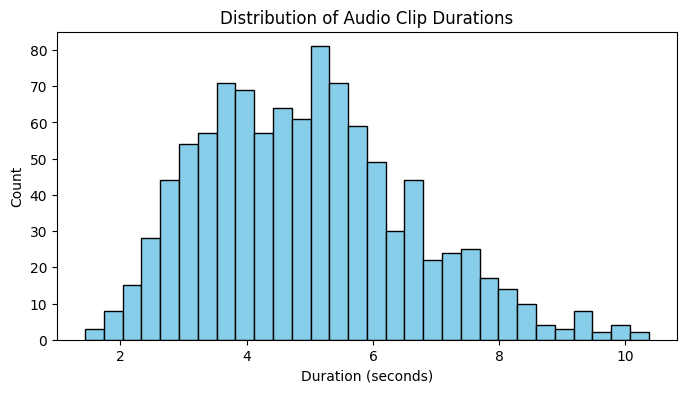

count    1000.000000
mean        4.957756
std         1.640340
min         1.440000
25%         3.696000
50%         4.860000
75%         5.958000
max        10.368000
Name: duration, dtype: float64


In [7]:
# Duration distribution
plt.figure(figsize=(8, 4))
plt.hist(df['duration'], bins=30, color='skyblue', edgecolor='black')
plt.xlabel("Duration (seconds)")
plt.ylabel("Count")
plt.title("Distribution of Audio Clip Durations")
plt.show()
print(df['duration'].describe())

In [8]:
# Transcripts analysis
text_files = glob.glob(os.path.join(extract_directory, '**/*.tsv'), recursive=True)
print(f'{len(text_files)} transcript files found')

texts = []
for file in text_files:
  tsv_df = pd.read_csv(file, sep='\t')
  texts.append(tsv_df)

df_text = pd.concat(texts, ignore_index=True)
df_text.head()

10 transcript files found


,sentence_id,sentence,sentence_domain,source,is_used,clips_count,client_id,path,up_votes,down_votes,age,gender,accents,variant,locale,segment,clip,duration[ms],reason
0,0055b21f72f75c57255023d47ff42ec2ea32c5cbea601e...,"Un rhywogaeth o ""Chesapecten"", ""Chesapecten je...",NaN,covost2-en_cy,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0f0f350ec00b70d51d713569c67be2ba30e7956335bd68...,"Dau rifyn yn ddiweddarach, fe’i datgelwyd fel ...",NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,11018db3f2d9b38b718748c364438602fdab986bff3613...,Cânt eu hadeiladu mewn meintiau pŵer hyd at al...,NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11b2ae9a9bd3043d7220ff56ecb41b5cbb31ec539fc2e3...,Mae mapio rhwydwaith yn canfod y dyfeisiau ar ...,NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11df6df7ee79e8c7c727c8ec35dac7f699d3e6dea1c2fc...,Mae modd cael mynediad uniongyrchol ar droed n...,NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df_text['sentence'].fillna('', inplace=True)
df_text['word_count'] = df_text['sentence'].fillna('').apply(lambda x: len(x.split()))
df_text['char_count'] = df_text['sentence'].fillna('').apply(len)
df_text.head()


,sentence_id,sentence,sentence_domain,source,is_used,clips_count,client_id,path,up_votes,down_votes,...,gender,accents,variant,locale,segment,clip,duration[ms],reason,word_count,char_count
0,0055b21f72f75c57255023d47ff42ec2ea32c5cbea601e...,"Un rhywogaeth o ""Chesapecten"", ""Chesapecten je...",NaN,covost2-en_cy,0.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,89
1,0f0f350ec00b70d51d713569c67be2ba30e7956335bd68...,"Dau rifyn yn ddiweddarach, fe’i datgelwyd fel ...",NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10,73
2,11018db3f2d9b38b718748c364438602fdab986bff3613...,Cânt eu hadeiladu mewn meintiau pŵer hyd at al...,NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,61
3,11b2ae9a9bd3043d7220ff56ecb41b5cbb31ec539fc2e3...,Mae mapio rhwydwaith yn canfod y dyfeisiau ar ...,NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,74
4,11df6df7ee79e8c7c727c8ec35dac7f699d3e6dea1c2fc...,Mae modd cael mynediad uniongyrchol ar droed n...,NaN,covost,1.0,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,70


          word_count     char_count
count  368804.000000  368804.000000
mean        6.398724      36.243238
std         5.467866      45.949959
min         0.000000       0.000000
25%         0.000000       0.000000
50%         7.000000      41.000000
75%        11.000000      60.000000
max       936.000000   15644.000000


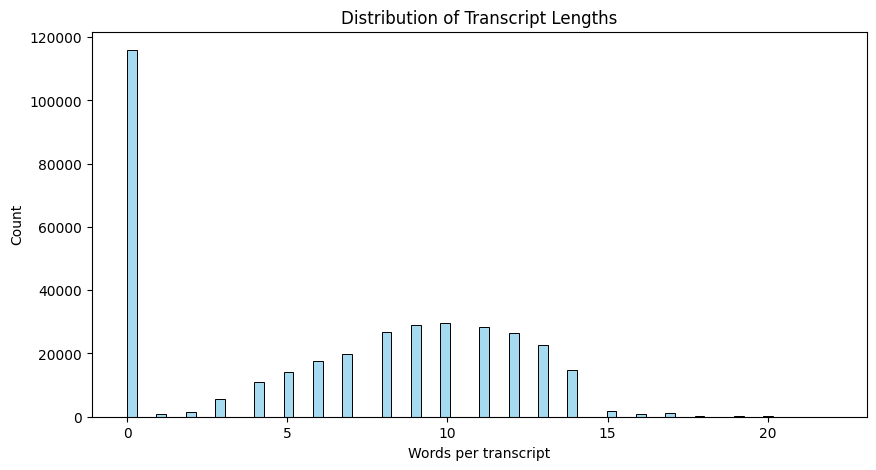

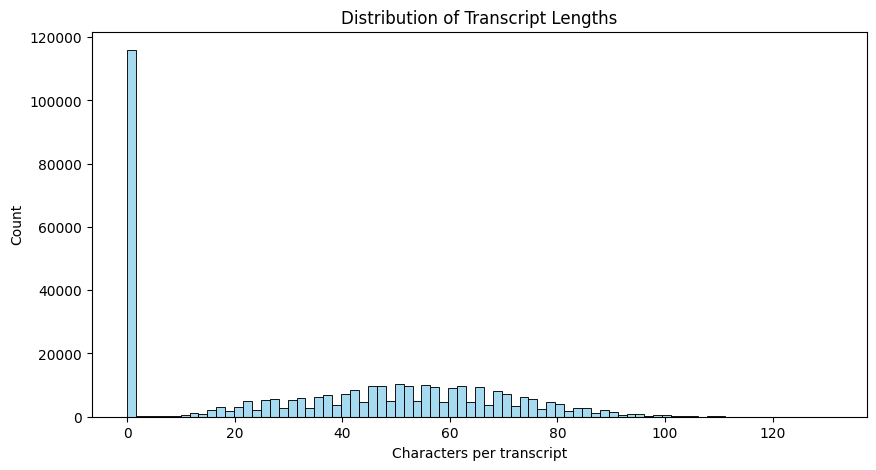

In [12]:
cols = ['sentence', 'word_count', 'char_count']
df_text_analysis = df_text[cols]
# Check distribution before removing outliers
print(df_text_analysis[['word_count', 'char_count']].describe())

# Remove outliers
Q1_wc = df_text_analysis['word_count'].quantile(0.25)
Q3_wc = df_text_analysis['word_count'].quantile(0.75)
IQR_wc = Q3_wc - Q1_wc
lower_wc = Q1_wc - 1.5 * IQR_wc
upper_wc = Q3_wc + 1.5 * IQR_wc

Q1_cc = df_text_analysis['char_count'].quantile(0.25)
Q3_cc = df_text_analysis['char_count'].quantile(0.75)
IQR_cc = Q3_cc - Q1_cc
lower_cc = Q1_cc - 1.5 * IQR_cc
upper_cc = Q3_cc + 1.5 * IQR_cc

# Filter out both word_count and char_count outliers
df_text_analysis = df_text_analysis[(df_text_analysis['word_count'].between(lower_wc, upper_wc)) & (df_text_analysis['char_count'].between(lower_cc, upper_cc))]

# Distribution of transcript length
plt.figure(figsize=(10, 5))
sns.histplot(df_text_analysis, x='word_count', color='skyblue', edgecolor='black')
plt.xlabel('Words per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths')
plt.show()

# Distribution of transcript char length
plt.figure(figsize=(10, 5))
sns.histplot(df_text_analysis, x='char_count', color='skyblue', edgecolor='black')
plt.xlabel('Characters per transcript')
plt.ylabel('Count')
plt.title('Distribution of Transcript Lengths')
plt.show()


In [13]:
sample_audio = audio_files[0]
print('Sample audio : ', sample_audio)
Audio(sample_audio)

Sample audio :  /content/dataset/cv-corpus-22.0-2025-06-20/cy/clips/common_voice_cy_23084011.mp3


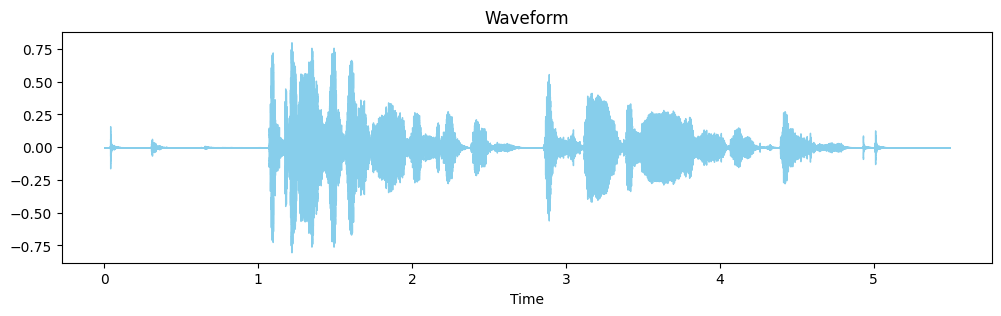

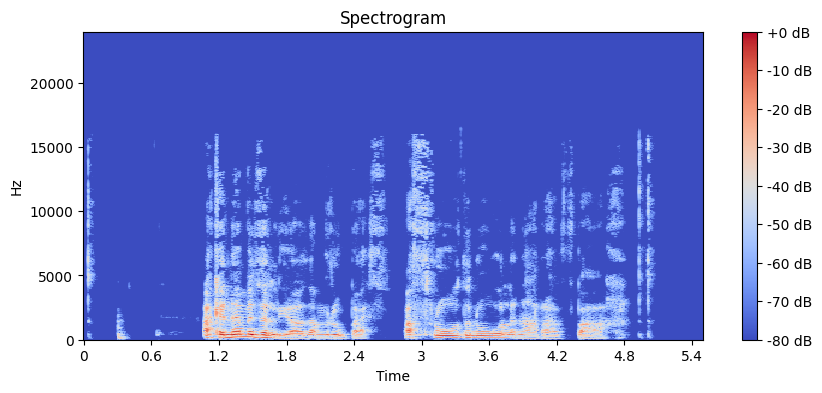

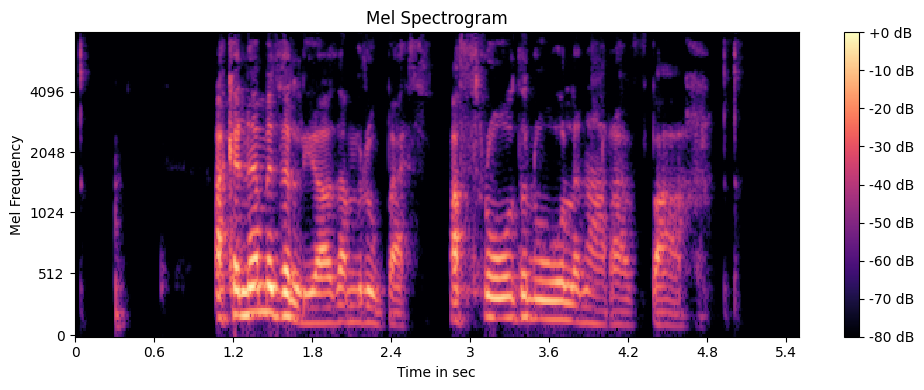

In [14]:
y, sr = librosa.load(sample_audio, sr=None)

# Waveform
plt.figure(figsize=(12, 3))
librosa.display.waveshow(y, sr=sr, color='skyblue')
plt.title('Waveform')
plt.show()

# Spectrogram
D = np.abs(librosa.stft(y))**2
S_db = librosa.power_to_db(D, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='coolwarm')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')

# Mel Spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
S_dB = librosa.power_to_db(S, ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_dB, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram')
plt.xlabel('Time in sec')
plt.ylabel('Mel Frequency')
plt.tight_layout()
plt.show()

# S2S

### Import libraries

In [39]:
# Import libraries
from tqdm import tqdm
from typing import List, Dict
from dataclasses import dataclass

### Prepare dataset

In [15]:
# Make dataset path
train_path, test_path, validated_path = None, None, None
for root, dirs, files in os.walk(extract_directory):
    for file in files:
        if file == 'train.tsv':
            train_path = os.path.join(root, file)
        elif file == 'test.tsv':
            test_path = os.path.join(root, file)
        elif file == 'validated.tsv':
            validated_path = os.path.join(root, file)

# Load datasets
if train_path and os.path.exists(train_path):
    train_df = pd.read_csv(train_path, sep='\t')
    print(f'train.tsv loaded {len(train_df)} samples')
else:
    print('train.tsv not found')

if test_path and os.path.exists(test_path):
    test_df = pd.read_csv(test_path, sep='\t')
    print(f'test.tsv loaded {len(test_df)} samples')
else:
    print('test.tsv not found')

if validated_path and os.path.exists(validated_path):
    validated_df = pd.read_csv(validated_path, sep='\t')
    print(f'validated.tsv loaded {len(validated_df)} samples')
else:
    print('validated.tsv not found')


train.tsv loaded 8014 samples
test.tsv loaded 5408 samples
validated.tsv loaded 90776 samples


In [16]:
# Combine train and test
if train_df is not None and test_df is not None:
    train_df = pd.concat([train_df, test_df], ignore_index=True)
else:
  print('train_df or test_df is None')

In [36]:
# Using subset of training data
train_df_subset = train_df.head(50)
val_df_subset = validated_df.head(10)

def load_audio_data(df : pd.DataFrame, audio_path : str, target_sr : int = 16000) -> List:
  """Load audio from dataframe and returns list of sampled waveforms"""

  audio = []
  for i, row in tqdm(df.iterrows(), total = len(df)):
    audio_file = os.path.join(audio_path, row['path'])  # Get audio path

    y, sr = librosa.load(audio_file, sr = None)
    if sr != 16000: # Resample to 16kHz
      y = librosa.resample(y, orig_sr=sr, target_sr=16000)
      sr = target_sr

    audio.append({'audio' : y, 'sr' : sr, 'sentence' : row['sentence'], 'path' : audio_file})
  return audio

train_dataset = load_audio_data(train_df_subset, audio_path)
val_dataset = load_audio_data(val_df_subset, audio_path)
train_dataset[0]

100%|██████████| 10/10 [00:00<00:00, 117.20it/s]


{'audio': array([ 3.4924597e-10, -2.3283064e-10,  5.8207661e-10, ...,
         4.7809897e-07, -1.5917853e-06, -5.1340453e-07], dtype=float32),
 'sr': 16000,
 'sentence': 'Ond mae rhywun annisgwyl yno i achub y dydd.',
 'path': '/content/dataset/cv-corpus-22.0-2025-06-20/cy/clips/common_voice_cy_24396707.mp3'}

### Audio prepocessing (making chunks)

In [38]:
# Chunking audio preprocessing
# Create functions to create chunks

@dataclass
class Chunk:
  """Chunk class to define metadata"""

  audio : np.ndarray
  chunk_id : int
  start_time : float
  end_time : float
  sr : int

class AudioChunk:
  """Split the audio into chunks for streaming"""

  def __init__(self, chunk_duration : float = 2.0, chunk_overlap : float = 0.5, target_sr : int = 16000):
    self.chunk_duration = chunk_duration
    self.chunk_overlap = chunk_overlap
    self.target_sr = target_sr

    self.chunk_samples = int(chunk_duration * target_sr)  # Number of audio samples in 2sec
    self.overlap_samples = int(chunk_overlap * target_sr) # Number of overlapping samples in 0.5sec

  def create_chunks(self, audio : np.ndarray, sr : int) -> List[Chunk]:
    """Create overlapping chunks from audio"""

    chunks, chunk_id = [], 0
    for idx in range(0, len(audio), self.overlap_samples):
      end_idx = idx + self.chunk_samples
      # If index exceeds length, then stop
      if end_idx > len(audio):
        break

      # Make chunks from audio
      chunked_audio = audio[idx:end_idx]

      # Pad last chunk if length is small
      if len(chunked_audio) < self.chunk_samples:
        chunked_audio = np.pad(chunked_audio, (0, self.chunk_samples - len(chunked_audio)), mode='constant')

      chunk = Chunk(chunked_audio, chunk_id, idx/self.target_sr, end_idx/self.target_sr, self.target_sr)
      chunks.append(chunk)
      chunk_id += 1

    return chunks

chunker = AudioChunk()

In [40]:
# Create chunks for dataset
def create_chunks_from_dataset(dataset : List[Dict]) -> List:
  """Create chunks from dataset"""

  dataset_chunk = []
  for idx, audio_sample in enumerate(dataset):
    chunks = chunker.create_chunks(audio_sample['audio'], audio_sample['sr']) # Create chunks from class method defined above
    for chunk in chunks:  # Append all chunks
      dataset_chunk.append({'chunk' : chunk,
                            'sample_id' : idx,  # Determine the audio sample number
                            'sentence' : audio_sample['sentence']})
  return dataset_chunk

train_dataset_chunk = create_chunks_from_dataset(train_dataset)
val_dataset_chunk = create_chunks_from_dataset(val_dataset)

In [51]:
train_dataset_chunk[0]

{'chunk': Chunk(audio=array([ 3.4924597e-10, -2.3283064e-10,  5.8207661e-10, ...,
         1.6058522e-01,  2.3157370e-01,  2.7099302e-01], dtype=float32), chunk_id=0, start_time=0.0, end_time=2.0, sr=16000),
 'sample_id': 0,
 'sentence': 'Ond mae rhywun annisgwyl yno i achub y dydd.'}

### Feeding to model